# Outlier Detection
## Introduction
### What is an Outlier and Why Detect Them?

**Definition**: An outlier is a data point that differs significantly from other observations in a dataset. These anomalies can arise due to variability in the measurement or experimental errors. Outliers are important to identify because they can lead to misleading analysis results or can indicate interesting phenomena.

**Why should be care?**  
In the context of data science, outliers can skew the results of data analysis, such as mean and standard deviation calculations. They can also affect the performance of machine learning models, leading to less accurate predictions. In all those cases outliers are data points that we often would like to **either exclude**, or at least treat **differently**. Think of a large dataset from a questionnaire where many thousands of people gave us answers. When we want to train a model to predict certain properties, we often might want to exclude outliers which could occur from people who did not fill in the questionnaire correctly. Or, we might consider not to "confuse" a model with rare data of a few people who are very different in their answers to the rest of our dataset.

In data science workflows, however, the opposite can happen as well. These are cases where the **outliers are our target data points**. An example of this is cases where we look for unintentional or unwanted behavior such as fraud in financial transactions or hacker attacks.

### Challenges in Outlier Detection

**Difficulty**: Detecting outliers is not trivial because it often depends on the context and the nature of the data. The challenge lies in distinguishing between a genuine outlier and a natural variation in the data.

**Approach**: To effectively detect outliers, data scientists must understand the underlying data distribution and choose appropriate methods for outlier identification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

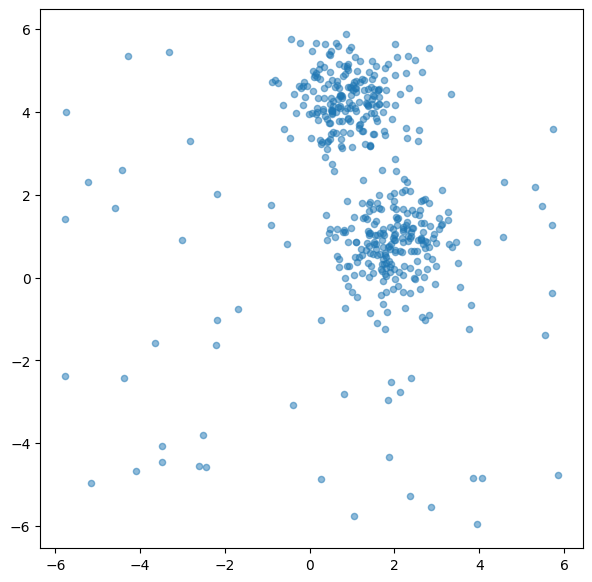

In [2]:
# Create dummy dataset
np.random.seed(0)

# Create toy data: 2 clusters and some additional random data
n_samples = 400
n_noise_samples = 70
clusters = make_blobs(n_samples=n_samples, centers=2, cluster_std=0.70, random_state=0)
random_data = np.random.uniform(low=-6, high=6, size=(n_noise_samples, 2))
X = np.vstack([clusters[0], random_data])

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0], X[:, 1], alpha=0.5, s=20)
plt.show()

## Method: Isolation Forest

### Concept and Theory

**Isolation Forest** (iForest) is an unsupervised learning algorithm for anomaly detection that works on the principle of isolating anomalies, instead of profiling normal data points. Developed 2008 {cite}`liu2008isolation`, it's particularly effective in datasets with a high dimensionality.

**Isolating Anomalies**: The core idea behind Isolation Forest is that anomalies are few and different, which makes them easier to isolate. In a dataset, anomalies are susceptible to being isolated with fewer random partitions compared to normal points.

**Tree Structure**: The algorithm builds an ensemble of isolation trees (iTrees) for the dataset. Each iTree is constructed by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. This process is repeated recursively until the data points are isolated or the tree reaches a certain height.

### Algorithm

**Construction of iTrees**: In an iTree, each node represents a test (split), and the path from the root to a leaf node is a set of conditions isolating a data point. The length of this path is a measure of normality: shorter paths indicate anomalies.

**Scoring Anomalies**: Once the iTrees are built, the algorithm assigns an anomaly score to each data point. The score is calculated based on the average path length across the trees in the forest. Shorter paths are indicative of anomalies.

**Ensemble Approach**: The use of multiple trees reduces the risk of overfitting and increases the robustness of the model.

### Implementation in Scikit-Learn

In [3]:
from sklearn.ensemble import IsolationForest

# Create the model
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=0)

# Fit the model
iso_forest.fit(X)

# Classify as outlier / no outlier
outlier_classification = iso_forest.predict(X)

**Parameters**:

To learn more about the many different parameters, see the [Scikit-Learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest).

- `n_estimators`: Number of iTrees in the forest.
- `contamination`: The proportion of outliers in the data set.
- `n_jobs`: The number of jobs to run in parallel.  `None` means no parallel jobs. `-1` means using all processors.
- `random_state`: Controls the randomness of the bootstrapping.

### Plot outlier classification
We can use the isolation forest to predict for each data point if it is an outlier or not. This is binary classification problem, so all data points will be assigned as outliers or inliers.

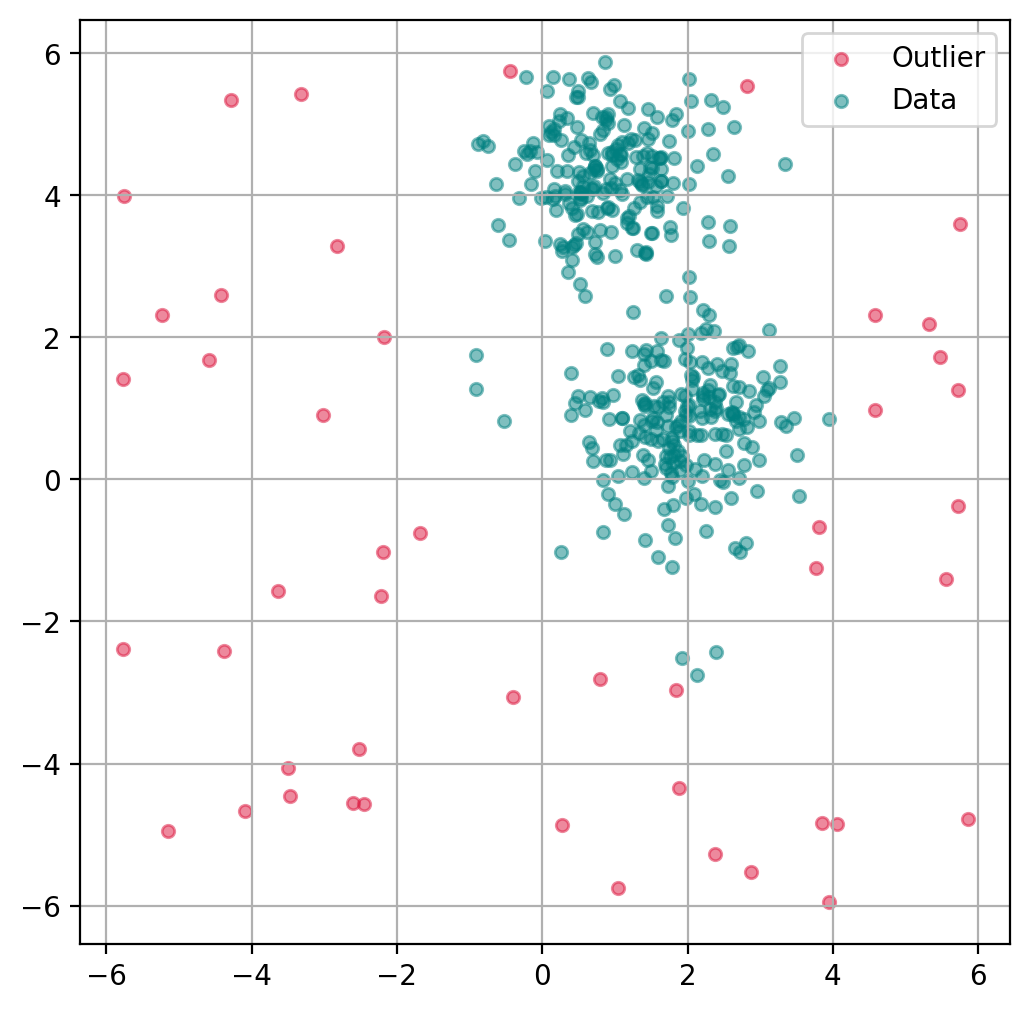

In [4]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)

# Scatter Plot: Outlier
mask = outlier_classification == -1
scatter = ax.scatter(X[mask, 0], X[mask, 1],
                     c="crimson",
                     alpha=0.5,
                     label="Outlier",
                     s=20)

# Data
scatter = ax.scatter(X[~mask, 0], X[~mask, 1],
                     c="teal",
                     alpha=0.5,
                     label="Data",
                     s=20)
plt.grid(True)
plt.legend()
plt.show()

### Plot data point "anomaly"
If a binary classification is not what we want, we can also try to use the models decision function to get a somewhat quantitative measure of the "anomaly" of each datapoint.

In [5]:
# Predict degree of anomaly
scores_pred = iso_forest.decision_function(X)

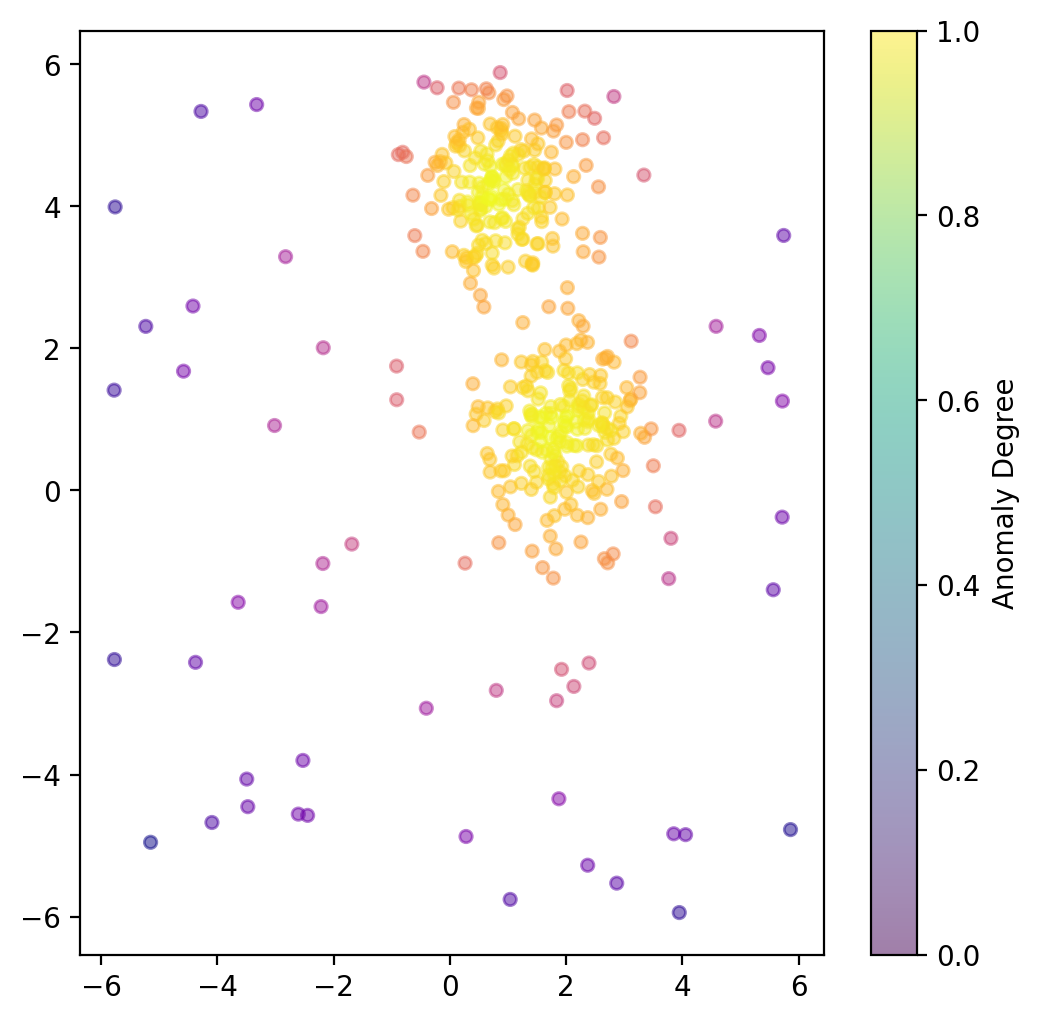

In [6]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
ax.scatter(X[:, 0], X[:, 1],
           c=scores_pred, cmap="plasma",
           alpha=0.5,
           s=20)

# Adding a colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Anomaly Degree')
plt.grid(True)
plt.show()

### Chose how sensitive the outlier detection should be

The parameter `contamination` is used as a threshold for the binary decision into outlier/non-outlier.
The actual underlying anomaly degree is not affected, as the plot below shows.

In [7]:
outlier_classifications = []
anomaly_degrees = []

for contamination in [0.01, 0.1, 0.2, 0.4]:

    # Create the model
    iso_forest = IsolationForest(
        n_estimators=100,
        contamination=contamination,
        n_jobs=-1,
        random_state=42)

    # Fit the model
    iso_forest.fit(X)

    # Classify as outlier / no outlier
    outlier_classifications.append(iso_forest.predict(X))
    anomaly_degrees.append(iso_forest.decision_function(X))

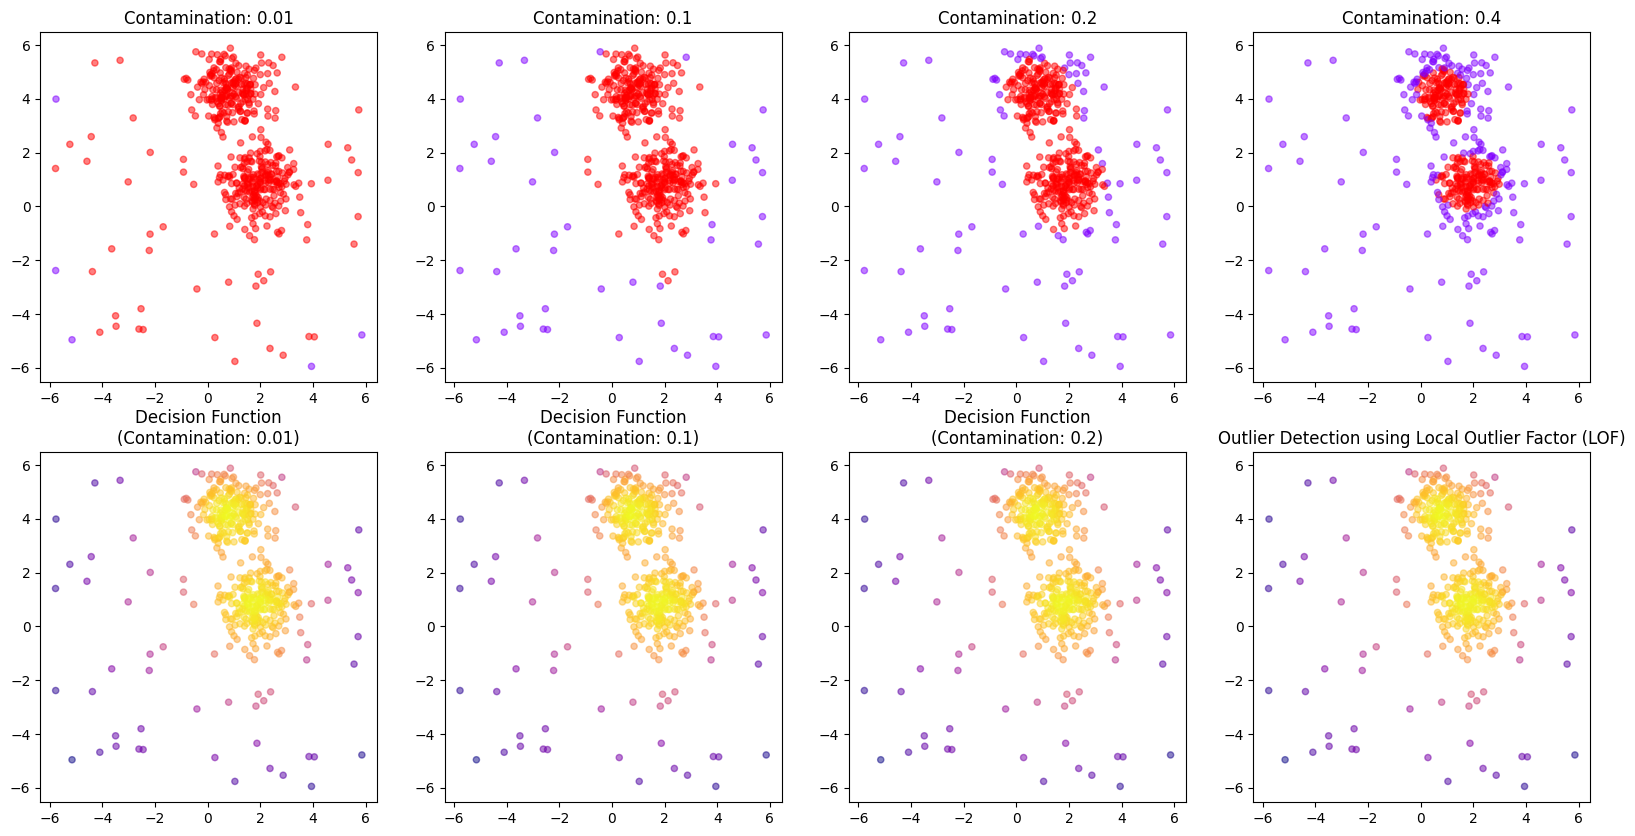

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, contamination in enumerate([0.01, 0.1, 0.2, 0.4]):
    axes[0, i].scatter(
        X[:, 0], X[:, 1],
        c=outlier_classifications[i], cmap="rainbow",
        alpha=0.5,
        s=20)
    axes[0, i].set_title(f"Contamination: {contamination}")

for i, contamination in enumerate([0.01, 0.1, 0.2, 0.4]):
    axes[1, i].scatter(
        X[:, 0], X[:, 1],
        c=anomaly_degrees[i], cmap="plasma",
        alpha=0.5,
        s=20)
    axes[1, i].set_title(f"Decision Function\n(Contamination: {contamination})")

plt.title("Outlier Detection using Local Outlier Factor (LOF)")
plt.show()

### Advantages

1. **Effectiveness in High-Dimensional Spaces**: Performs well in high-dimensional datasets where traditional distance-based methods might falter.
2. **Scalability**: Due to its tree structure, it scales well with large datasets.
3. **Low False Positive Rate**: Tends to have a lower false positive rate compared to other anomaly detection methods.
4. **Unsupervised Method**: Does not require labeled data, making it suitable for scenarios where labeling is impractical.


Isolation Forest stands out for its simplicity, effectiveness, and scalability in detecting anomalies, especially in high-dimensional data. Its unsupervised nature makes it a go-to method for various applications where identifying rare events is crucial. The implementation in Python's scikit-learn library provides a user-friendly and efficient way to leverage this powerful algorithm.

## Method: Local Outlier Factor (LOF)

### Concept and Background

**Local Outlier Factor (LOF)** is an algorithm designed for detecting local outliers, introduced in 2000 {cite}`breunig2000lof`. It's particularly effective in identifying outliers in datasets where the density varies across different regions.

**Local Density Estimation**: LOF relies on the concept of local density, where locality is given by the k-nearest neighbors of a point. It compares the local density of a point to the densities of its neighbors. An outlier will have a substantially lower density than its neighbors.

### Algorithm

**Defining Local Reachability Density (LRD)**: The LRD of a point measures how reachable the point is based on the distances to its neighbors. A lower LRD indicates an outlier.

**Calculating LOF Score**: The LOF score of a point is the ratio of the average LRD of its neighbors to its own LRD. Points with an LOF significantly greater than 1 are considered outliers.

**Key Steps**:

1. Find the k-nearest neighbors of each point.
2. Calculate the reachability distance of each point from its neighbors.
3. Compute the LRD for each point.
4. Determine the LOF score for each point.

In [9]:
from sklearn.neighbors import LocalOutlierFactor

# Create the model
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.1,
    metric_params=None,
    n_jobs=-1)

# Fit the model and classify outliers
outlier_classification = lof.fit_predict(X)

**Parameters**:

To learn more about the many different parameters, see the [Scikit-Learn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor).

- `n_neighbors`: Number of neighbors to use.
- `contamination`: The proportion of outliers in the dataset.
- `n_jobs`: Number of parallel jobs to run. `None` means no parallel jobs. `-1` means using all processors.

### Advantages

1. **Effectiveness in Varying Density**: Excellent for datasets where the density is not uniform.
2. **Flexibility**: Can work with different distance metrics, making it adaptable to various types of data.
3. **Unsupervised Nature**: Like Isolation Forest, it does not require labeled data.
4. **Local Anomaly Detection**: Superior at detecting anomalies that are only outliers within their local neighborhood.


Local Outlier Factor is a powerful tool for detecting anomalies, especially in datasets with non-uniform densities. Its ability to focus on local neighborhoods makes it unique compared to more global methods. The implementation in Python's scikit-learn makes it accessible and practical for a wide range of applications in anomaly detection.

### Plot outlier classification
Just as with the isolation forest, we can use LOF to predict for each data point if it is an outlier or not.

In [10]:
ax.get_legend_handles_labels()

([], [])

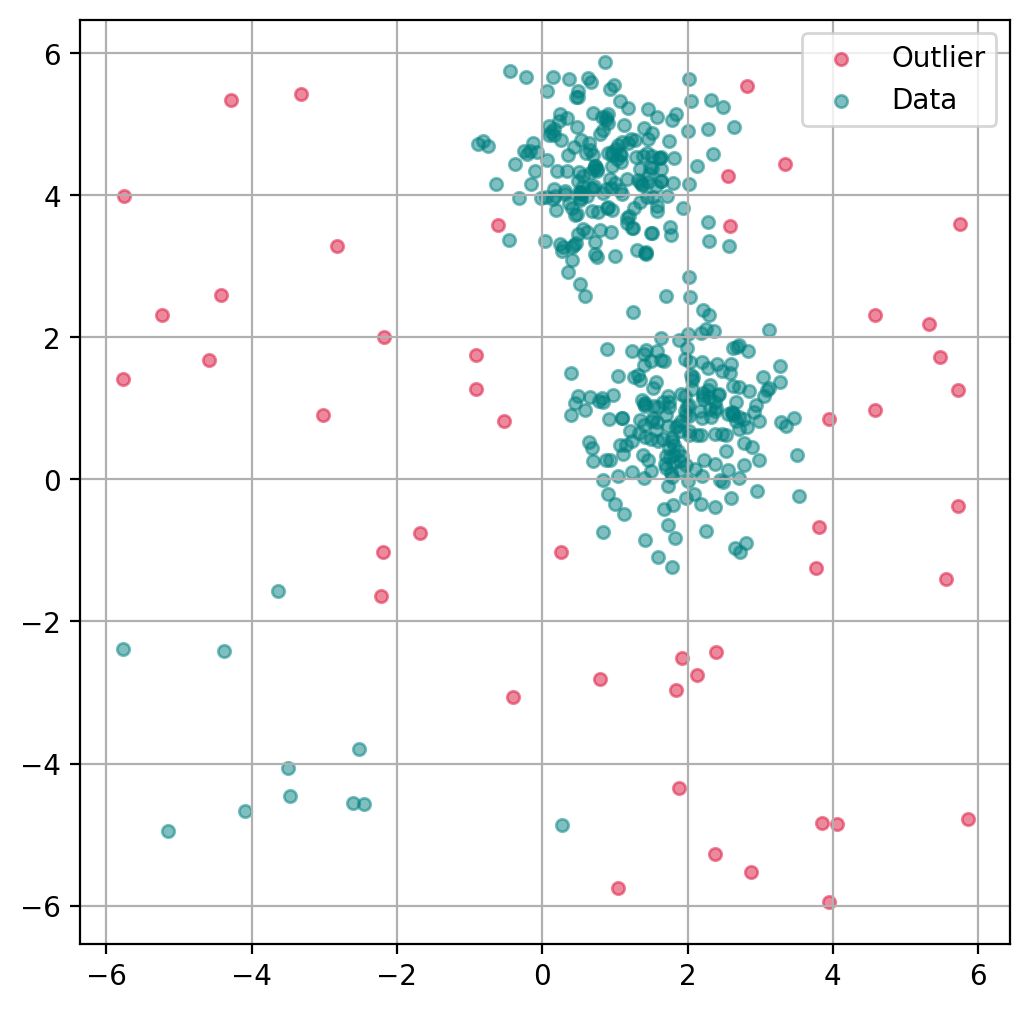

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(6, 6), dpi=200)

# Scatter Plot: Outlier
mask = outlier_classification == -1
scatter = ax.scatter(X[mask, 0], X[mask, 1],
                     c="crimson",
                     alpha=0.5,
                     label="Outlier",
                     s=20)

# Data
scatter = ax.scatter(X[~mask, 0], X[~mask, 1],
                     c="teal",
                     alpha=0.5,
                     label="Data",
                     s=20)
plt.grid(True)
plt.legend()
plt.show()


### Plot data point "anomaly"
If a binary classification is not what we want, we can also try to use the models decision function to get a somewhat quantitative measure of the "anomaly" of each datapoint.

In [12]:
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.1,
    novelty=True,  # this has to be set to True to later get anomaly ratings
    n_jobs=-1)

lof.fit(X)

# Predict degree of anomaly
anomaly_prediction = lof.decision_function(X)

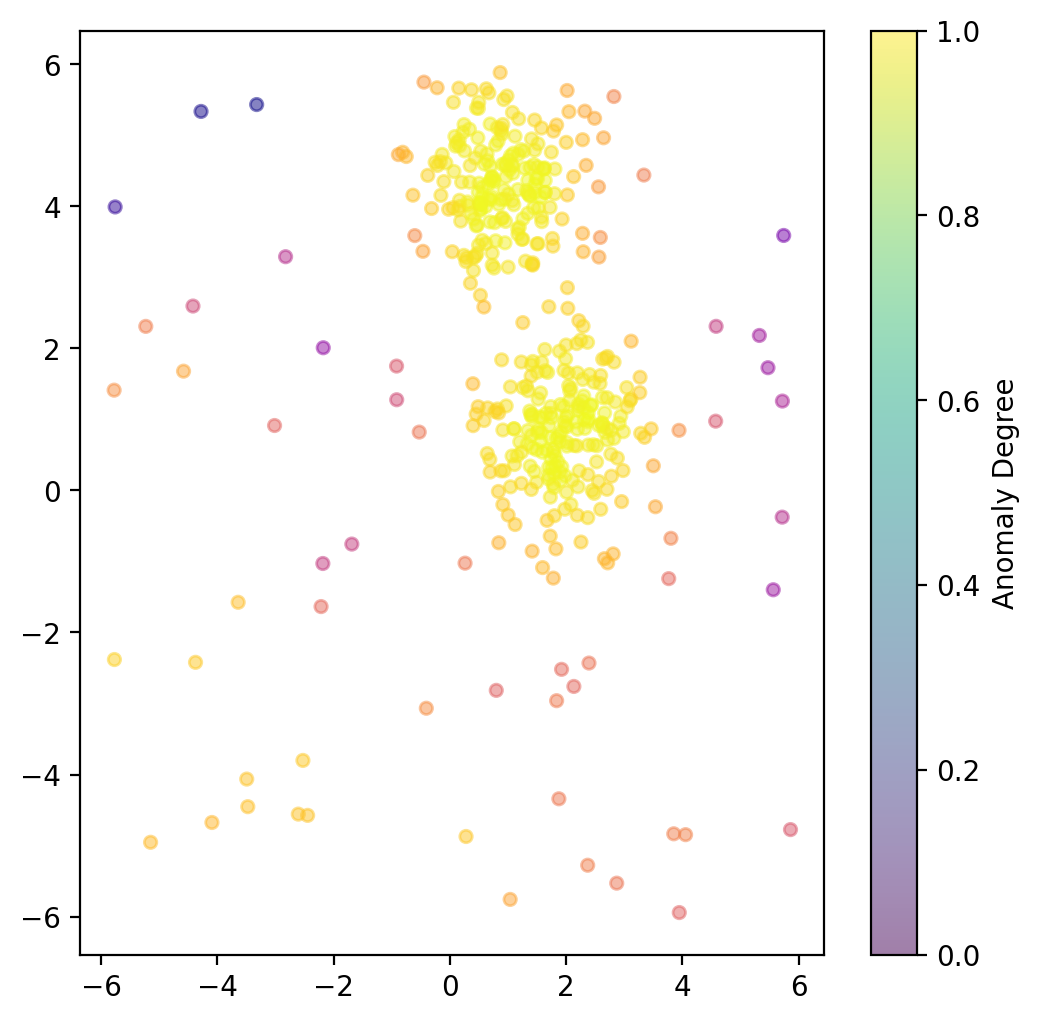

In [13]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
ax.scatter(X[:, 0], X[:, 1],
           c=anomaly_prediction, cmap="plasma",
           alpha=0.5,
           s=20)

# Adding a colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Anomaly Degree')
plt.grid(True)
plt.show()

### Chose how sensitive the outlier detection should be

Here again, we can use the parameter `contamination` to set the threshold for the binary decision into outlier/non-outlier.

In [14]:
outlier_classifications = []
anomaly_degrees = []

for contamination in [0.01, 0.1, 0.2, 0.4]:

    lof = LocalOutlierFactor(
        n_neighbors=20,
        contamination=contamination,
        novelty=True,  # this has to be set to True to later get anomaly ratings
        n_jobs=-1)

    # Fit the model
    lof.fit(X)

    # Classify as outlier / no outlier
    outlier_classifications.append(lof.predict(X))
    anomaly_degrees.append(lof.decision_function(X))

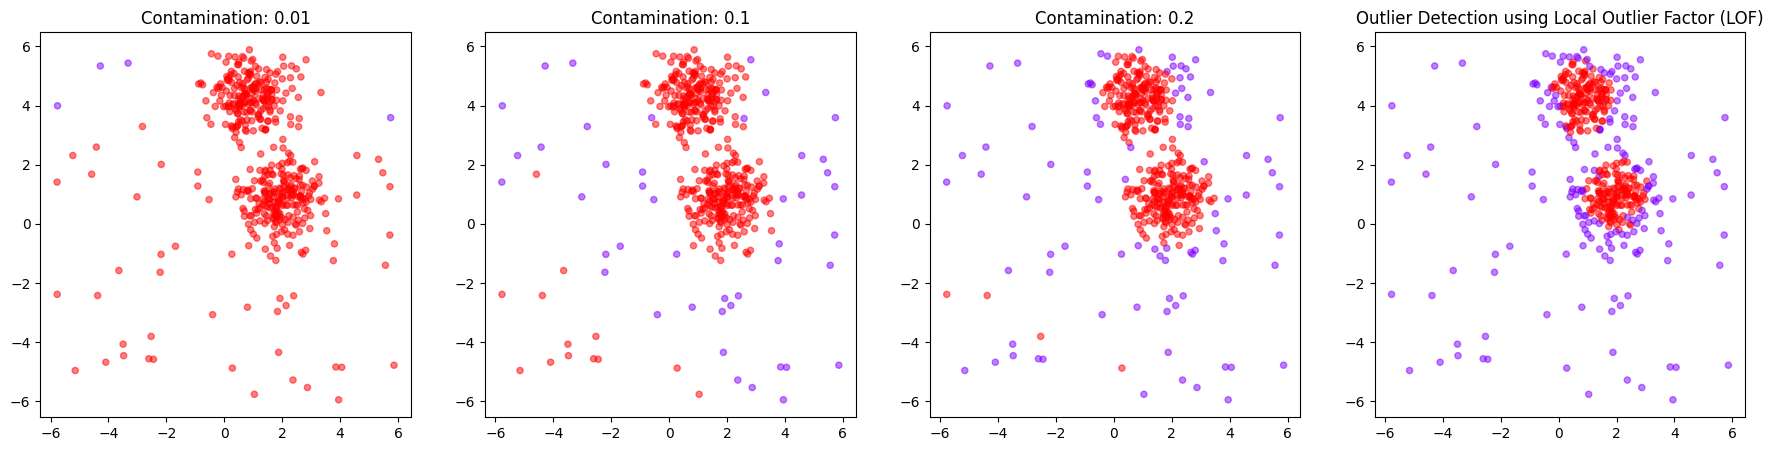

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(22, 5))

for i, contamination in enumerate([0.01, 0.1, 0.2, 0.4]):
    axes[i].scatter(
        X[:, 0], X[:, 1],
        c=outlier_classifications[i], cmap="rainbow",
        alpha=0.5,
        s=20)
    axes[i].set_title(f"Contamination: {contamination}")
plt.title("Outlier Detection using Local Outlier Factor (LOF)")
plt.show()